In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from itertools import product
import time

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# Load the dataset
print("Loading data...")
df = pd.read_csv('https://raw.githubusercontent.com/sebastiansossah/TFM/main/data/df.zip', index_col=0)

# Parse timestamps and sort
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.set_index('Timestamp')
df = df.sort_index()

print(f"Data Loaded. Shape: {df.shape}")

Loading data...


C:\Users\sebastian sossa\AppData\Local\Temp\ipykernel_7904\367505352.py:3: DtypeWarning: Columns (3,4,5,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('https://raw.githubusercontent.com/sebastiansossah/TFM/main/data/df.zip', index_col=0)


Data Loaded. Shape: (116166, 99)


In [ ]:
def create_sliding_windows(df, window_size, stride, test_size=0.2):
    """
    Creates sliding windows with a rigorous Train/Test split for Semi-Supervised Learning.
    
    Logic:
    1. Extract all windows.
    2. Separate into 'Pure Normal' and 'Anomaly' lists.
    3. Split 'Pure Normal' -> 80% Train, 20% Test.
    4. Add ALL 'Anomaly' windows to Test.
    
    Returns:
        windows_train: List of purely normal windows (for training).
        windows_test: List of mixed normal/anomaly windows (for evaluation).
        y_test: Ground truth labels for windows_test (0=Normal, 1=Anomaly).
    """
    if 'Block_ID' not in df.columns or 'Anomaly_Event' not in df.columns:
        print("Error: DataFrame must contain 'Block_ID' and 'Anomaly_Event'")
        return None, None, None
    
    normal_windows = []
    anomaly_windows = []
    
    # 1. Iterate over blocks to respect time continuity within blocks
    for block_id in sorted(df['Block_ID'].unique()):
        block_data = df[df['Block_ID'] == block_id].copy()
        
        for i in range(0, len(block_data) - window_size + 1, stride):
            window = block_data.iloc[i:i+window_size]
            
            # Check if window has ANY anomaly record
            if window['Anomaly'].any():
                anomaly_windows.append(window)
            else:
                normal_windows.append(window)
                
    # 2. Split the Normal Windows (Train vs Validation)
    # random_state ensures reproducibility for the thesis
    norm_train, norm_test = train_test_split(normal_windows, test_size=test_size, random_state=42)
    
    # 3. Construct Final Sets
    windows_train = norm_train
    # Test set = Unseen Normals + All Anomalies
    windows_test = norm_test + anomaly_windows
    
    # 4. Create Labels for Test Set
    # 0 = Normal, 1 = Anomaly
    y_test = np.concatenate([
        np.zeros(len(norm_test)), 
        np.ones(len(anomaly_windows))
    ])
    
    print(f"--- Data Split Summary (Window={window_size}, Stride={stride}) ---")
    print(f"Train Windows (Normal): {len(windows_train)}")
    print(f"Test Windows (Mixed):   {len(windows_test)} ({len(norm_test)} Normal + {len(anomaly_windows)} Anomalies)")
    
    return windows_train, windows_test, y_test

In [4]:
def prepare_data_model_with_pca(windows_train, windows_test, pca_components=None):
    """
    Flattens windows, Scales features, and optionally applies PCA.
    Crucial: Fits scaler/PCA ONLY on Train data to prevent data leakage.
    """
    # 1. Feature Definition
    continuous_features = [
        'FIT101', 'LIT101', 'AIT201', 'AIT202', 'AIT203', 'FIT201',
        'AIT301', 'AIT302', 'AIT303', 'DPIT301', 'FIT301', 'LIT301',
        'AIT401', 'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502', 
        'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504',
        'PIT501', 'PIT502', 'PIT503', 'FIT601', 'FIT602', 'LIT601', 'LIT602'
    ]
    binary_features = [
        'MV101', 'P101', 'P102', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206',
        'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'P401', 'P402', 'P403', 'P404', 'UV401',
        'MV501', 'MV502', 'MV503', 'MV504', 'P501', 'P502', 'P601', 'P602', 'P603'
    ]
    all_features = continuous_features + binary_features
    
    # 2. Extract Arrays
    X_train = np.array([w[all_features].values for w in windows_train])
    X_test = np.array([w[all_features].values for w in windows_test])
    
    n_cont = len(continuous_features)
    window_size = X_train.shape[1]
    
    # 3. Scale Continuous Features
    # Reshape to (N_samples * Window_Size, N_features) for scaling
    X_train_cont = X_train[:, :, :n_cont].reshape(-1, n_cont)
    X_test_cont = X_test[:, :, :n_cont].reshape(-1, n_cont)
    
    scaler = StandardScaler()
    X_train_cont = scaler.fit_transform(X_train_cont) # FIT on Train
    X_test_cont = scaler.transform(X_test_cont)       # TRANSFORM Test
    
    # Reshape back to windows
    X_train_cont = X_train_cont.reshape(X_train.shape[0], window_size, n_cont)
    X_test_cont = X_test_cont.reshape(X_test.shape[0], window_size, n_cont)
    
    # 4. Recombine with Binary Features
    X_train_bin = X_train[:, :, n_cont:]
    X_test_bin = X_test[:, :, n_cont:]
    
    X_train_final = np.concatenate([X_train_cont, X_train_bin], axis=2)
    X_test_final = np.concatenate([X_test_cont, X_test_bin], axis=2)
    
    # Flatten for Model Input: (N_Windows, Window_Size * Features)
    X_train_flat = X_train_final.reshape(X_train_final.shape[0], -1)
    X_test_flat = X_test_final.reshape(X_test_final.shape[0], -1)
    
    pca = None
    if pca_components is not None:
        print("se aplica pca")
        pca = PCA(n_components=pca_components)
        X_train_flat = pca.fit_transform(X_train_flat) # FIT on Train
        X_test_flat = pca.transform(X_test_flat)       # TRANSFORM Test
        
    return X_train_flat, X_test_flat, scaler, pca

In [ ]:
EXPERIMENT_CONFIG = {
    'strides': [5, 15, 30],       
    'pca':[10,20,60],
    'window_size': [60],
    "contamination": [0.001, 0.005, 0.01, 0.02, "auto"],
    "max_samples": [128, 256, 512],
    "max_features": [0.5, 0.7, 1.0],
    "n_estimators": [100, 200, 300, 400,500,600,700,800]   
}

In [6]:
count= 0
for i in product(EXPERIMENT_CONFIG['strides'], 
            EXPERIMENT_CONFIG['max_samples'], 
            EXPERIMENT_CONFIG['max_features'], 
            EXPERIMENT_CONFIG['contamination'],
            EXPERIMENT_CONFIG['n_estimators']
            ):
    count+=1
print(count)

1080


In [7]:
print(3*5*3*3*8)

1080


In [ ]:
results = []
start_time_total = time.time()

# 1. OUTER LOOP: Data Generation (Expensive part done once per stride)
for stride, pca_param,window_size in product(EXPERIMENT_CONFIG['strides'], EXPERIMENT_CONFIG['pca'],EXPERIMENT_CONFIG['window_size']):
    windows_train, windows_test, metadata_train, metadata_test = create_sliding_windows(
                    df, 
                    window_size=window_size, 
                    stride=stride)

    X_train, X_test, scaler, pca, all_features = prepare_data_model_with_pca(
        windows_train, 
        windows_test, 
        pca_components=pca_param)
    
    print(f"Data prepared for Stride {stride}. Starting Grid Search...")
    
    # 2. INNER LOOP: Model Hyperparameters
    param_grid = product(
        EXPERIMENT_CONFIG["contamination"],
        EXPERIMENT_CONFIG["max_samples"],
        EXPERIMENT_CONFIG["max_features"],
        EXPERIMENT_CONFIG["n_estimators"]
    )
    
    for cont, max_samp, max_feat, n_est in param_grid:
        
        # Train Model
        iso = IsolationForest(
            n_estimators=n_est,
            max_samples=max_samp,
            contamination=cont,
            max_features=max_feat,
            random_state=42,
            n_jobs=-1
        )
        
        iso.fit(X_train)
        
        preds = iso.predict(X_test)
        y_pred_binary = np.where(preds == -1, 1, 0)
        f1 = f1_score(y_test_true, y_pred_binary)
        
        results.append({
            'stride': stride,
            'pca':pca_param,
            'contamination': cont,
            'max_samples': max_samp,
            'max_features': max_feat,
            'n_estimators': n_est,
            'f1': f1,
        })

print(f"\nExperiment Complete! Total time: {time.time() - start_time_total:.2f} seconds")

--- Data Split Summary (Window=60, Stride=5) ---
Train Windows (Normal): 11706
Test Windows (Mixed):   11413 (2927 Normal + 8486 Anomalies)
se aplica pca
Data prepared for Stride 5. Starting Grid Search...
--- Data Split Summary (Window=60, Stride=5) ---
Train Windows (Normal): 11706
Test Windows (Mixed):   11413 (2927 Normal + 8486 Anomalies)
se aplica pca
Data prepared for Stride 5. Starting Grid Search...
--- Data Split Summary (Window=60, Stride=5) ---
Train Windows (Normal): 11706
Test Windows (Mixed):   11413 (2927 Normal + 8486 Anomalies)
se aplica pca
Data prepared for Stride 5. Starting Grid Search...


KeyboardInterrupt: 

In [ ]:
# Convert to DataFrame
results_df = pd.DataFrame(results)

# Sort by F1 Score to see best configuration
results_df = results_df.sort_values(by='f1', ascending=False)

print("--- TOP 10 CONFIGURATIONS ---")
print(results_df.head(10))

# Get best params
best_config = results_df.iloc[0]
print("\n--- WINNER CONFIGURATION ---")
print(best_config)

--- TOP 10 CONFIGURATIONS ---
      stride contamination  max_samples  max_features  n_estimators        f1
291        5          auto          128           0.5           400  0.557152
290        5          auto          128           0.5           300  0.556298
651       15          auto          128           0.5           400  0.544132
292        5          auto          128           0.5           500  0.536747
655       15          auto          128           0.5           800  0.534861
652       15          auto          128           0.5           500  0.530752
653       15          auto          128           0.5           600  0.529571
654       15          auto          128           0.5           700  0.528922
293        5          auto          128           0.5           600  0.524437
1012      30          auto          128           0.5           500  0.520575

--- WINNER CONFIGURATION ---
stride                  5
contamination        auto
max_samples           128
max_

In [ ]:
results_df.head(10)

,stride,contamination,max_samples,max_features,n_estimators,f1
291,5,auto,128,0.5,400,0.557152
290,5,auto,128,0.5,300,0.556298
651,15,auto,128,0.5,400,0.544132
292,5,auto,128,0.5,500,0.536747
655,15,auto,128,0.5,800,0.534861
652,15,auto,128,0.5,500,0.530752
653,15,auto,128,0.5,600,0.529571
654,15,auto,128,0.5,700,0.528922
293,5,auto,128,0.5,600,0.524437
1012,30,auto,128,0.5,500,0.520575


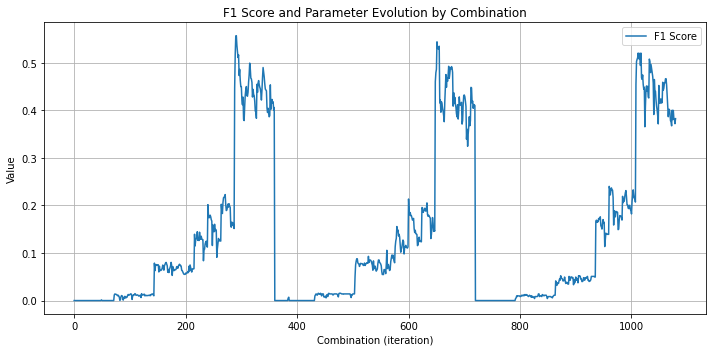

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Reset iteration index
results_df_g = results_df.reset_index().rename(columns={'index': 'iteration'}).sort_values(by='iteration')


plt.figure(figsize=(10, 5))

# Plot F1
plt.plot(results_df_g['iteration'], results_df_g['f1'], label='F1 Score')

plt.xlabel('Combination (iteration)')
plt.ylabel('Value')
plt.title('F1 Score and Parameter Evolution by Combination')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Re-run the best model to see the confusion matrix
best_stride = int(best_config['stride'])

# 1. Re-create data
w_train, w_test, y_test_true = create_sliding_windows_improved(df, 60, best_stride, 0.2)
X_train, X_test, _, _ = prepare_data_model_with_pca(w_train, w_test, pca_components=10)

# 2. Re-train model
best_iso = IsolationForest(
    n_estimators=int(best_config['n_estimators']),
    max_samples=int(best_config['max_samples']),
    contamination=best_config['contamination'],
    max_features=best_config['max_features'],
    random_state=42,
    n_jobs=-1
)
best_iso.fit(X_train)

# 3. Report
preds = best_iso.predict(X_test)
y_pred = np.where(preds == -1, 1, 0)

print("\nClassification Report:")
print(classification_report(y_test_true, y_pred, target_names=['Normal', 'Anomaly']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_true, y_pred))

--- Data Split Summary (Window=60, Stride=5) ---
Train Windows (Normal): 11706
Test Windows (Mixed):   11413 (2927 Normal + 8486 Anomalies)
se aplica pca

Classification Report:
              precision    recall  f1-score   support

      Normal       0.32      0.81      0.46      2927
     Anomaly       0.86      0.41      0.56      8486

    accuracy                           0.51     11413
   macro avg       0.59      0.61      0.51     11413
weighted avg       0.72      0.51      0.53     11413


Confusion Matrix:
[[2375  552]
 [4996 3490]]
